<a href="https://colab.research.google.com/github/renatafrustockl/Bootcamp-IGTI---analista-de-Machine-Learning/blob/main/CAP_4_ML_RENATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

carregar um conjunto de dados de imagens usando tf.data.

In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os 

In [6]:
tf.__version__

'2.4.1'

In [ ]:
usar um arquivo de fotos de flores licenciadas da creative-commons do Google.
O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.
Se quiser conferir o banco de imagens, baixe as fotos de:
http://download.tensorflow.org/example_images/flower_photos.tgz

In [7]:
import pathlib

In [8]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos',untar='True')
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


Após o download (218MB), você deve ter uma cópia das fotos da flor disponível.
O diretório contém 5 subdiretórios, um por classe:

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

O count retornará 3670 imagens.

In [12]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['roses', 'sunflowers', 'dandelion', 'tulips', 'daisy'],
      dtype='<U10')

Cada diretório contém imagens desse tipo de flor. Aqui estão algumas rosas:

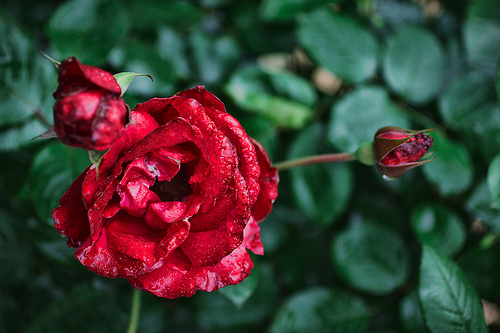

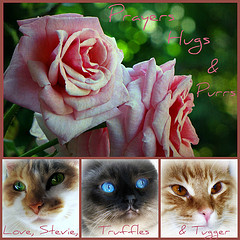

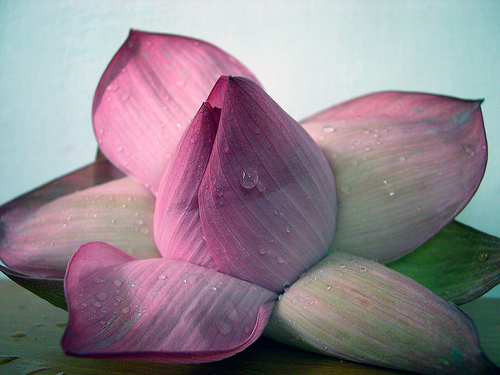

In [15]:
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

Carregar usando keras.preprocessing
Uma maneira simples de carregar imagens é usar tf.keras.preprocessing.

In [16]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Defina alguns parâmetros para a carga:

In [17]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [18]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size = BATCH_SIZE,
                                                     shuffle = True,
                                                     target_size = (IMG_HEIGHT,IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


O resultado será 3670 imagens pertencendo a 5 classes.

Inspecione o lote:

In [23]:
def show_batch(image_batch,label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

In [24]:
image_batch,label_batch = next(train_data_gen)


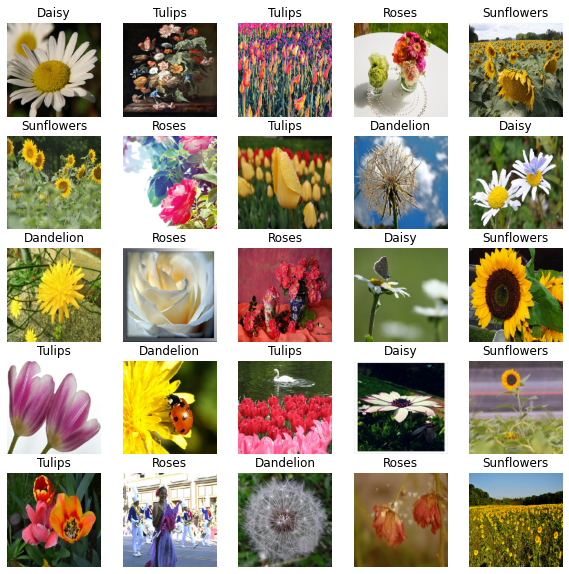

In [25]:
show_batch(image_batch,label_batch)

Carregar usando tf.data
O método keras.preprocessing acima é conveniente, mas tem três desvantagens:
1)	É lento. Veja a seção de desempenho abaixo.
2)	Falta controle refinado.
3)	Não está bem integrado ao restante do TensorFlow.
Para carregar os arquivos como um tf.data.Dataset, primeiro crie um conjunto de dados dos caminhos do arquivo:

In [26]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [27]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/483880052_19fdb26a9f.jpg'
b'/root/.keras/datasets/flower_photos/roses/14683774134_6367640585.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/16832961488_5f7e70eb5e_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/7308600792_27cff2f73f.jpg'
b'/root/.keras/datasets/flower_photos/tulips/133960364_d87f883c15_n.jpg'


Escreva uma função pure-tensorflow que converte um caminho de arquivo em um par (img, label):

In [37]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path,os.path.sep)
  # the second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [42]:
def decode_img(img):
  # convert the compressed string to a 30 unit tensor
  img = tf.image.decode_jpeg(img,channels=3)
  # use convert_image_dtype to convert to floats in the [0,1] range
  img = tf.image.convert_image_dtype(img,tf.float32)
  # resize the image for the desired size
  return tf.image.resize(img,[IMG_HEIGHT,IMG_WIDTH])

In [43]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map para criar um conjunto de dados de imagem, pares de rótulos:

In [ ]:
# Set 'num_parallel_calls' so multiple image are loaded/processed in parallell

In [44]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [45]:
for image, label in labeled_ds.take(1):
  print('Image shape: ', image.numpy().shape)
  print('Label: ', label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


O resultado será:
Image shape:  (224, 224, 3)
Label:  [False False  True False False]

Métodos básicos para treinamento
Para treinar um modelo com esse conjunto de dados, você deseja os dados:
•	Estar bem embaralhado.
•	Para ser agrupado.
•	Os lotes devem estar disponíveis o mais rápido possível.
Esses recursos podem ser facilmente adicionados usando a API tf.data.

In [46]:
def prepare_for_training(ds, cache=True,shuffle_buffer_size=1000):
  # this is a small dataset, onl load it once, and keep it in memory.
  # use '.cache(filename)' to cache preprocessing work for datasets that don't
  # fit in memory
  if cache:
    if isinstance(cache,str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size) 

  # Repeat forever
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  # 'prefetch' lets the dataset fetch batches in the background while the model
  # is training
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [49]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

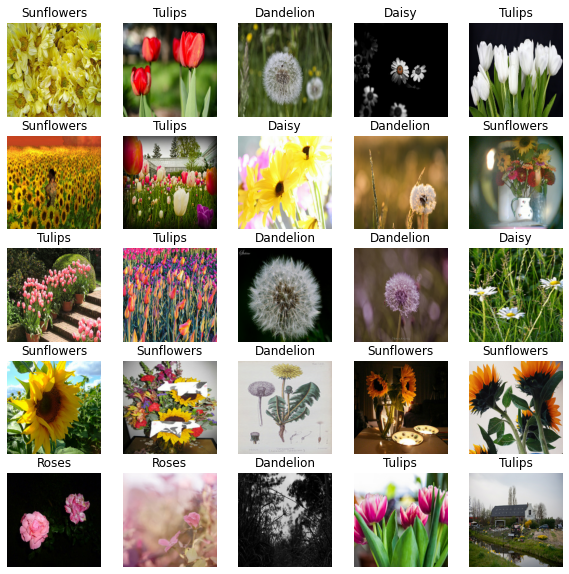

In [50]:
show_batch(image_batch.numpy(),label_batch.numpy())

Performance:
Para investigar, primeiro aqui está uma função para verificar o desempenho de nossos conjuntos de dados:

In [51]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps,duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Vamos comparar a velocidade dos dois geradores de dados:

In [52]:
# keras.preprocessing
timeit(train_data_gen)

.
1000 batches: 0.1359093189239502 s
235451.11000 Images/s

1000 batches: 0.2366013526916504 s
135248.59277 Images/s

1000 batches: 0.33514928817749023 s
95479.83877 Images/s

1000 batches: 0.43759751319885254 s
73126.55816 Images/s

1000 batches: 0.5314357280731201 s
60214.24287 Images/s

1000 batches: 0.629098653793335 s
50866.42581 Images/s

1000 batches: 0.7568590641021729 s
42279.99837 Images/s

1000 batches: 0.8530395030975342 s
37512.91691 Images/s

1000 batches: 0.9692316055297852 s
33015.84453 Images/s

1000 batches: 1.0863492488861084 s
29456.45706 Images/s
.
1000 batches: 1.2091953754425049 s
26463.87891 Images/s

1000 batches: 1.3121936321258545 s
24386.64479 Images/s

1000 batches: 1.414973497390747 s
22615.26457 Images/s

1000 batches: 1.5176396369934082 s
21085.37443 Images/s

1000 batches: 1.613797903060913 s
19829.00086 Images/s

1000 batches: 1.710644006729126 s
18706.40523 Images/s

1000 batches: 1.8233001232147217 s
17550.59389 Images/s

1000 batches: 1.930983304977

1000 batches: 76.91638088226318 s
416.03622 Images/s

In [54]:
# tf.data
timeit(train_ds)

.
1000 batches: 0.025612354278564453 s
1249397.05472 Images/s

1000 batches: 0.033196210861206055 s
963965.43972 Images/s

1000 batches: 0.03992795944213867 s
801443.41076 Images/s

1000 batches: 0.04781770706176758 s
669208.16506 Images/s

1000 batches: 0.05545473098754883 s
577047.24971 Images/s

1000 batches: 0.06260466575622559 s
511144.01161 Images/s

1000 batches: 0.07026171684265137 s
455440.05239 Images/s

1000 batches: 0.07682967185974121 s
416505.74870 Images/s

1000 batches: 0.08377194404602051 s
381989.46395 Images/s

1000 batches: 0.09020233154296875 s
354758.01404 Images/s
.
1000 batches: 0.09619784355163574 s
332647.78937 Images/s

1000 batches: 0.10390233993530273 s
307981.51437 Images/s

1000 batches: 0.10969877243041992 s
291707.91333 Images/s

1000 batches: 0.11722946166992188 s
272968.92389 Images/s

1000 batches: 0.12363886833190918 s
258818.28612 Images/s

1000 batches: 0.13175702095031738 s
242871.30788 Images/s

1000 batches: 0.13812732696533203 s
231670.30524 I

1000 batches: 5.537988185882568 s
5778.27163 Images/s

Grande parte do ganho de desempenho vem do uso de .cache.

In [55]:
uncached_ds = prepare_for_training(labeled_ds,cache = False)
timeit(uncached_ds)

.
1000 batches: 2.2945172786712646 s
13946.28853 Images/s

1000 batches: 2.3655354976654053 s
13527.59239 Images/s

1000 batches: 2.4279732704162598 s
13179.71676 Images/s

1000 batches: 2.4953136444091797 s
12824.03920 Images/s

1000 batches: 2.559967279434204 s
12500.15977 Images/s

1000 batches: 2.6236181259155273 s
12196.89698 Images/s

1000 batches: 2.691432237625122 s
11889.58041 Images/s

1000 batches: 2.7561912536621094 s
11610.22478 Images/s

1000 batches: 2.8274288177490234 s
11317.70314 Images/s

1000 batches: 2.8933351039886475 s
11059.90107 Images/s
.
1000 batches: 2.9622740745544434 s
10802.51158 Images/s

1000 batches: 3.023829460144043 s
10582.60739 Images/s

1000 batches: 3.106790542602539 s
10300.01848 Images/s

1000 batches: 3.1764254570007324 s
10074.21721 Images/s

1000 batches: 3.2378482818603516 s
9883.10669 Images/s

1000 batches: 3.3044557571411133 s
9683.89422 Images/s

1000 batches: 3.373351812362671 s
9486.11404 Images/s

1000 batches: 3.437617301940918 s
93

1000 batches: 20.565682888031006 s
1555.99015 Images/s

Se o conjunto de dados não couber na memória, use um arquivo de cache para manter algumas das vantagens:

In [56]:
filecache_ds = prepare_for_training(labeled_ds, cache = "./flowers.tfcache")
timeit(filecache_ds)

.
1000 batches: 3.1875979900360107 s
10038.90707 Images/s

1000 batches: 3.276881456375122 s
9765.38225 Images/s

1000 batches: 3.363556146621704 s
9513.74040 Images/s

1000 batches: 3.5129740238189697 s
9109.09098 Images/s

1000 batches: 3.631917715072632 s
8810.77230 Images/s

1000 batches: 3.7454566955566406 s
8543.68442 Images/s

1000 batches: 3.852182388305664 s
8306.97947 Images/s

1000 batches: 3.942796230316162 s
8116.06741 Images/s

1000 batches: 4.033198833465576 s
7934.14888 Images/s

1000 batches: 4.141428470611572 s
7726.80253 Images/s
.
1000 batches: 4.225924730300903 s
7572.30714 Images/s

1000 batches: 4.336866617202759 s
7378.59907 Images/s

1000 batches: 4.481622695922852 s
7140.27087 Images/s

1000 batches: 4.612911224365234 s
6937.05091 Images/s

1000 batches: 4.7189013957977295 s
6781.23939 Images/s

1000 batches: 4.820131301879883 s
6638.82330 Images/s

1000 batches: 4.925989866256714 s
6496.15628 Images/s

1000 batches: 5.024880886077881 s
6368.31016 Images/s

10

1000 batches: 14.327738761901855 s
2233.42989 Images/s